In [ ]:
# Import the required packages

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, MeanShift, estimate_bandwidth, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [ ]:
# Set visual style for plots
plt.style.use('seaborn')

In [ ]:
# Import pre-processed dataset and load it into a dataframe

# Create path variables
scaled_file = 'preprocessed.csv'
original_file = 'non_preprocessed.csv'

# Load csv in dataframe
df = pd.read_csv(scaled_file, index_col=0)
dfo = pd.read_csv(original_file, index_col=0)

In [ ]:
# Check # of columns and rows imported
df.shape

(15710, 91)

In [ ]:
# Check # of columns and rows imported
dfo.shape

(15710, 27)

In [ ]:
# Creates working numpy array from dataset
x_cols = df.to_numpy()

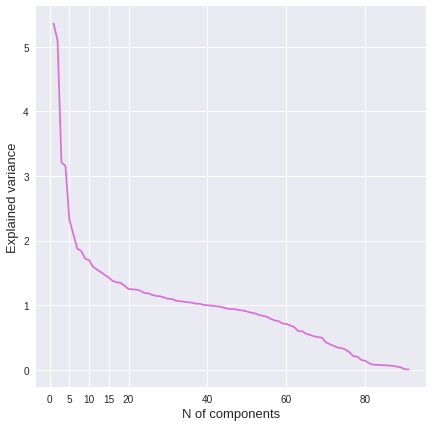

In [ ]:
colors = ["#DA70D6"]
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))

# Initialize a new PCA model with a default number of components.
pca = PCA()
pca.fit(x_cols)

# Compute the explained variance by component
explained_variance = pca.explained_variance_

# Plot explained variance
fig = plt.figure(figsize=(7,7))
plt.plot(np.arange(1,92,1), explained_variance)
plt.xlabel('N of components', fontsize=13)
plt.ylabel('Explained variance', fontsize=13)
plt.xticks([0,5,10,15,20,40,60,80])
plt.show()

In [ ]:
# Initializes PCA with the 3 components

pca = PCA(n_components=3)
x_3cols = pca.fit_transform(x_cols)

In [ ]:
# Creates empty list to store inertia values
iner = []

# Calculates inertia for the number of clusters selected 
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i).fit(x_3cols)
    iner.append(kmeans.inertia_)

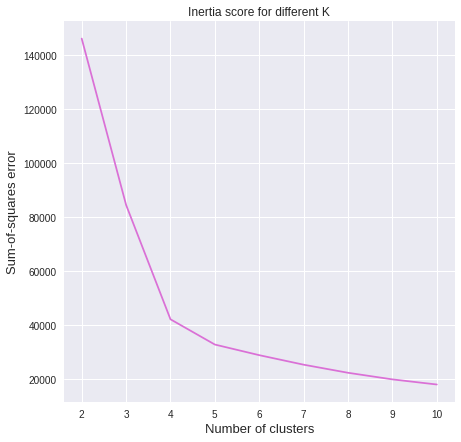

In [ ]:
# Creates x axis for the plot with number of clusters
xs = np.arange(2, 11, 1)

# Creates figure and plot
fig, ax1 = plt.subplots(figsize=(7,7))
ax1.plot(xs, iner)
ax1.set_title('Inertia score for different K')
ax1.set_xlabel('Number of clusters', fontsize=13)
ax1.set_xticks([2,3,4,5,6,7,8,9,10])
ax1.set_ylabel('Sum-of-squares error', fontsize=13)

plt.show()

In [ ]:
t_sne = TSNE(learning_rate=5, n_jobs=-1)
transformed = t_sne.fit_transform(x_3cols)
xs = transformed[:,0]
ys = transformed[:,1]

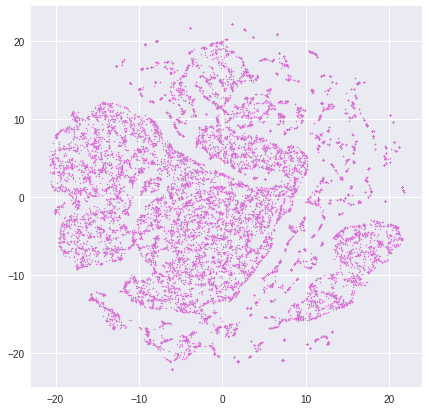

In [ ]:
fig = plt.figure(figsize=(7, 7))
plt.scatter(xs, ys, s=5, marker='.')
plt.show()

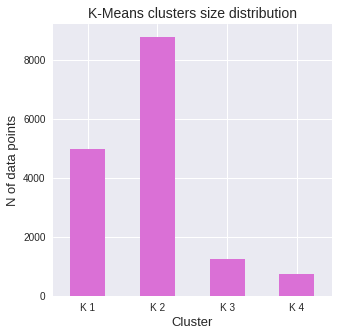

In [ ]:
# Initializes the model with selected K, fit and predict the labels for the dataset
kmeans = KMeans(n_clusters=4, random_state=42).fit(x_3cols)
labels_km = kmeans.predict(x_3cols)

# Creates dataframe with the labels
kmeans_df = pd.DataFrame(labels_km, columns=['cluster_id'])

# Create plot
fig = plt.figure(figsize=(5, 5))
kmeans_df.value_counts().sort_index().plot.bar()
plt.xlabel('Cluster', fontsize=13)
plt.title('K-Means clusters size distribution', fontsize=14)
plt.ylabel('N of data points', fontsize=13)
plt.xticks(ticks=[0,1,2,3], labels=['K 1','K 2','K 3','K 4'], rotation=0)
plt.show()

In [ ]:
# Initialize the pca with 2 components and fit and transform the original dataset
pca = PCA(n_components=2)
x_new = pca.fit_transform(x_cols)

# Create df with the principal components and assign column names
pca_df = pd.DataFrame(x_new, columns=['x', 'y'])

# Joins labels to 2-component dataset
customer_seg = kmeans_df.join(pca_df)

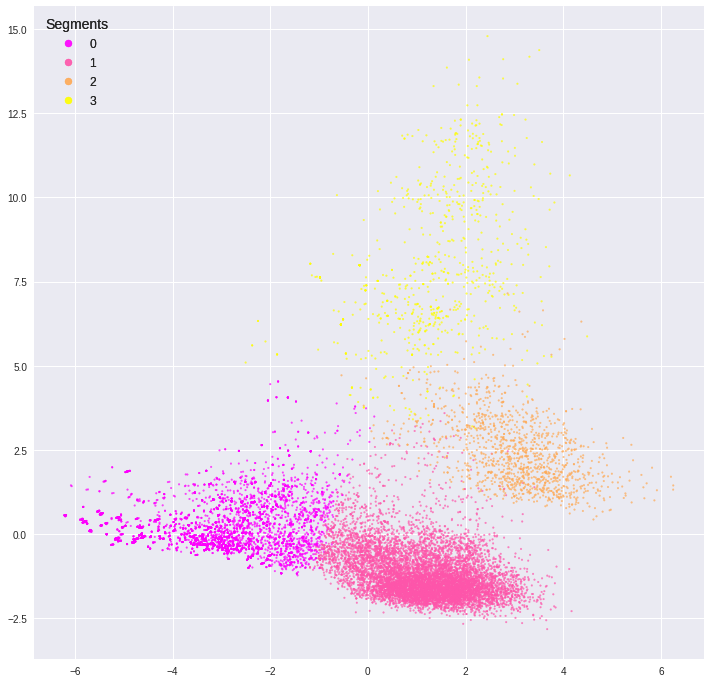

In [ ]:

# Creates plot
fig, ax = plt.subplots(figsize=(12, 12))
scatter = ax.scatter('x', 'y', c='cluster_id', data=customer_seg, alpha=0.7, s=3, cmap='spring')
legend = ax.legend(*scatter.legend_elements(), loc="upper left", title="Segments", fontsize=12, title_fontsize=14)
ax.add_artist(legend)

plt.show()

In [ ]:
# Reset index in original dataset
dfo.reset_index(inplace=True)
dfo.drop(['index'], axis=1, inplace=True)

# Adds cluster labels to original dataset
dfo_cat_labeled = dfo.select_dtypes(exclude='float64').join(kmeans_df)
dfo_num_labeled = dfo.select_dtypes(include='float64').join(kmeans_df)

In [ ]:
# Group observations by cluster label and aggregate for most common value in categories
segments_df_cat = dfo_cat_labeled.groupby(by='cluster_id').agg(lambda x:x.value_counts().index[0])

# Group observations by cluster label and aggregate for mean value in numerical columns
segments_df_num = dfo_num_labeled.groupby(by='cluster_id').median()

In [ ]:
# Shows categorical attributes per segment
segments_df_cat.T

cluster_id,0,1,2,3
ArrivalDateMonth,September,August,August,May
StaysInWeekendNights,0,0,0,0
StaysInWeekNights,2,2,1,1
Meal,BB,BB,BB,BB
Country,National,Other_Europe,National,National
MarketSegment,Groups,Online TA,Direct,Corporate
DistributionChannel,TA/TO,TA/TO,Direct,Corporate
IsRepeatedGuest,0,0,0,0
PreviousCancellations,0,0,0,0
PreviousBookingsNotCanceled,0,0,0,0


In [ ]:
# shows numerical attributes per segment
segments_df_num.T

cluster_id,0,1,2,3
LeadTime,158.00,59.000,22.0,8.0
Adults,2.00,2.000,2.0,1.0
Children,0.00,0.000,0.0,0.0
Babies,0.00,0.000,0.0,0.0
ADR,89.25,108.925,111.8,75.0
